## Importing required Libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean 

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data/train_data_complete.csv")

In [3]:
print(data.shape)
data.head()

(762, 2)


,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2


In [4]:
data.dtypes

Date     object
count     int64
dtype: object

In [5]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

data.index = data['Date']

# Exploring the Data

In [6]:
data.shape

(762, 2)

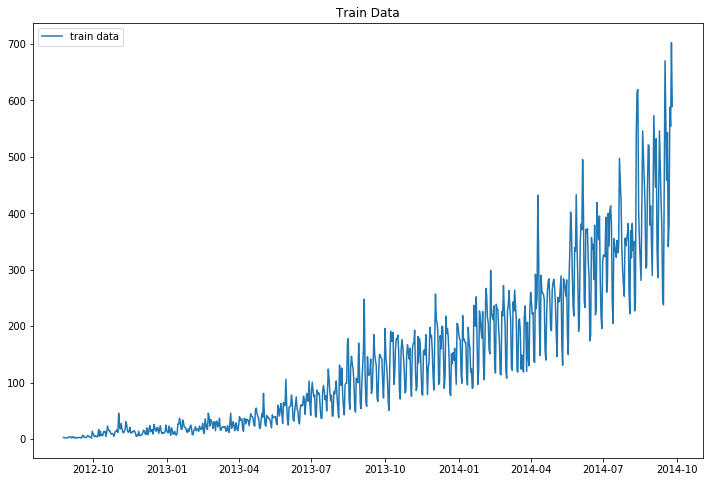

In [7]:
plt.figure(figsize=(12,8))

plt.plot(data.Date, data['count'], label='train data')

plt.legend(loc='best')
plt.title("Train Data")
plt.show()

### Check for Missing Values

In [8]:
data.shape

(762, 2)

In [9]:
data['Date'].min(), data['Date'].max()

(Timestamp('2012-08-25 00:00:00'), Timestamp('2014-09-25 00:00:00'))

In [10]:
data['Date'].max() - data['Date'].min()

Timedelta('761 days 00:00:00')

- No missing values in the data

In [11]:
data.head()

,Date,count
Date,,
2012-08-25,2012-08-25,3
2012-08-26,2012-08-26,3
2012-08-27,2012-08-27,2
2012-08-28,2012-08-28,2
2012-08-29,2012-08-29,2


- We have the daily level data. Let us find out if there is any pattern in the data. 
    - Is the count high on any particular day of the week?
    - Will the weekend have any effect on the count?
    - Is the count higher/ lower on particular month of the year?
    - How is the count changing over the years? Is it increasing or decreasing or constant?

# Adding features to the data

In [12]:
data_feat = pd.DataFrame({"year": data['Date'].dt.year,
                          "month": data['Date'].dt.month,
                          "day": data['Date'].dt.day,
                          "dayofyear": data['Date'].dt.dayofyear,
                          "week": data['Date'].dt.week,
                          "weekday": data['Date'].dt.dayofweek,
                          "quarter": data['Date'].dt.quarter,
                         })
data_feat.head()

,year,month,day,dayofyear,week,weekday,quarter
Date,,,,,,,
2012-08-25,2012,8,25,238,34,5,3
2012-08-26,2012,8,26,239,34,6,3
2012-08-27,2012,8,27,240,35,0,3
2012-08-28,2012,8,28,241,35,1,3
2012-08-29,2012,8,29,242,35,2,3


In [13]:
complete_data = pd.concat([data_feat, data['count']], axis=1)
complete_data.head()

,year,month,day,dayofyear,week,weekday,quarter,count
Date,,,,,,,,
2012-08-25,2012,8,25,238,34,5,3,3
2012-08-26,2012,8,26,239,34,6,3,3
2012-08-27,2012,8,27,240,35,0,3,2
2012-08-28,2012,8,28,241,35,1,3,2
2012-08-29,2012,8,29,242,35,2,3,2


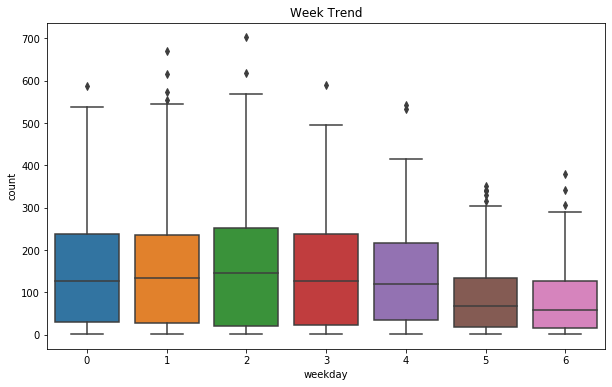

In [14]:
# boxplot for week's count
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['weekday'], y=complete_data['count'], )
plt.title('Week Trend')
plt.show()

- The count is lower on the weekends (saturday and sunday)
- Average count is higher on the weekdays

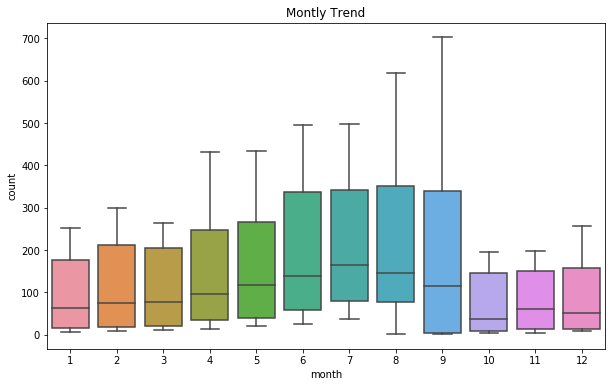

In [15]:
# boxplot for month's count
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['month'], y=complete_data['count'], )
plt.title('Montly Trend')
plt.show()

- The first and the last months have observed a significantly lower average count. 

Let us check the average for each quarter.

In [16]:
quarter_average = pd.DataFrame(complete_data.groupby('quarter')['count'].mean())
quarter_average

,count
quarter,
1,101.700000
2,159.324176
3,201.601852
4,79.630435


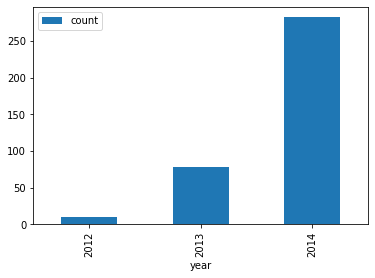

In [17]:
yearly_average = pd.DataFrame(complete_data.groupby('year')['count'].mean())
yearly_average
yearly_average.plot(kind='bar')

# Time Series Cross Validation

In [18]:
from sklearn.model_selection import TimeSeriesSplit

In [19]:
time_series_cv = TimeSeriesSplit(n_splits=5)
print(time_series_cv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [20]:
for train_index, test_index in time_series_cv.split(data):
    print('----- ----- ----')
    print("TRAIN:", train_index[0], 'to', train_index[-1])
    print("TEST:", test_index[0], 'to', test_index[-1])

----- ----- ----
TRAIN: 0 to 126
TEST: 127 to 253
----- ----- ----
TRAIN: 0 to 253
TEST: 254 to 380
----- ----- ----
TRAIN: 0 to 380
TEST: 381 to 507
----- ----- ----
TRAIN: 0 to 507
TEST: 508 to 634
----- ----- ----
TRAIN: 0 to 634
TEST: 635 to 761


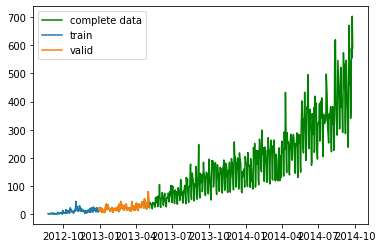

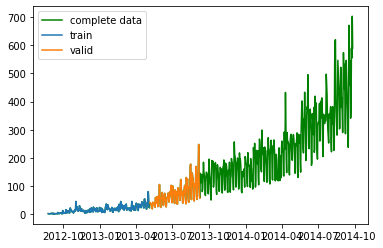

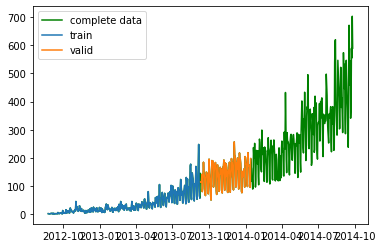

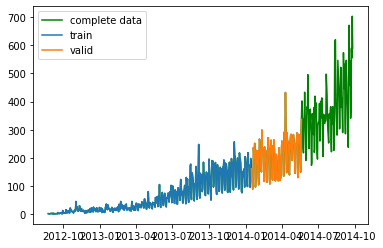

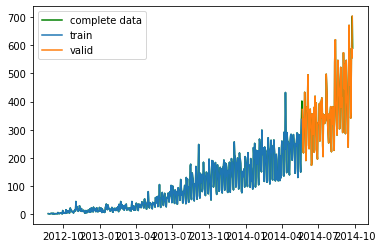

In [21]:
plt.figure(figsize=(6,4))

for train_index, test_index in time_series_cv.split(data):
    plt.plot(data.index, data['count'], label='complete data', color='green')

    plt.plot(data[train_index[0]:train_index[-1]].index,data['count'][train_index[0]:train_index[-1]],label='train')
    plt.plot(data[test_index[0]:test_index[-1]].index,data['count'][test_index[0]:test_index[-1]],label='valid')
    
    plt.legend(loc='best')
    plt.show()

# Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

#### Creating train and valid sets

In [23]:
model = LinearRegression(normalize=True)

In [24]:
i = 0
for train_index, test_index in time_series_cv.split(data):
    print('----- ----- ----')
    print("TRAIN:", train_index[0], 'to', train_index[-1])
    print("TEST:", test_index[0], 'to', test_index[-1])
    
    x_train = (complete_data[train_index[0]:train_index[-1]]).drop('count', axis=1)
    y_train = (complete_data[train_index[0]:train_index[-1]]['count'])
    x_valid = (complete_data[test_index[0]:test_index[-1]]).drop('count', axis=1)
    y_valid = (complete_data[test_index[0]:test_index[-1]]['count'])
    
    print('Model training on set', i+1)
    model.fit(x_train,y_train)
    preds_valid = model.predict(x_valid)
    rmse = sqrt(mean_squared_error(y_valid, preds_valid))
    print('The RMSE value is', rmse)
    i=i+1

----- ----- ----
TRAIN: 0 to 126
TEST: 127 to 253
Model training on set 1
The RMSE value is 75.59680818327199
----- ----- ----
TRAIN: 0 to 253
TEST: 254 to 380
Model training on set 2
The RMSE value is 43.41602478271454
----- ----- ----
TRAIN: 0 to 380
TEST: 381 to 507
Model training on set 3
The RMSE value is 41.35785290787165
----- ----- ----
TRAIN: 0 to 507
TEST: 508 to 634
Model training on set 4
The RMSE value is 63.98681455252648
----- ----- ----
TRAIN: 0 to 634
TEST: 635 to 761
Model training on set 5
The RMSE value is 145.4477605226813
